In [1]:
import requests
import json
import urllib
import pandas
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from pandas import DataFrame as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score

warnings.filterwarnings("ignore")
np.random.seed(40)        

# Variables 

In [2]:
days_into_future_target = 2
mname = "RandomForestClassifier"
model_type = "classifier"
experiment_name = "stock.classifier"

look_back = [1,2,3,4,5,7,10,15,20,24]

# Data engineering 

In [3]:
df = pandas.read_csv("dataset.csv")
del df["Unnamed: 0"]
df.head()

,adjusted_close,close,date,dividend_amount,high,id,low,open,split_coefficient,symbol,volume
0,10.6408,131.13,1998-01-02,0.0,131.50,MSFT1998-01-02,129.50,129.63,1.0,MSFT,4968500
1,10.5799,130.38,1998-01-05,0.0,133.63,MSFT1998-01-05,127.87,131.25,1.0,MSFT,10047200
2,10.6408,131.13,1998-01-06,0.0,133.00,MSFT1998-01-06,129.25,129.75,1.0,MSFT,8479300
3,10.5134,129.56,1998-01-07,0.0,131.19,MSFT1998-01-07,127.50,129.88,1.0,MSFT,7686600
4,10.5897,130.50,1998-01-08,0.0,132.13,MSFT1998-01-08,127.50,128.63,1.0,MSFT,9702400


In [4]:
target = (df["adjusted_close"].shift(-days_into_future_target) - df["adjusted_close"]) / df["adjusted_close"]
targetBin = target.map(lambda x: x>0)

In [5]:
assert df.shape[0] == target.shape[0]

# Training 

In [6]:
class stockTransformer(BaseEstimator, ClassifierMixin):
    def __init__(self, look_back):
        self.days_look_back = look_back

    def fit(self, X, y=None):
        return self

    def _meaning(self, x):
        return(True)

    def transform(self, tmp, y=None):
        #Vi tittar tillbaka {i} dagar
        try:
            for j in self.days_look_back:
                for c in ["adjusted_close", "high", "low", "open", "volume"]:
                    tmp["hist_{}_{}".format(c,j)] = (tmp[c].shift(j) - tmp[c]) / tmp[c]

            # Date -> month / day
            tmp.date = tmp.date.astype(str)
            tmp["month"] = tmp["date"].apply(lambda x : str(x).split("-")[1])
            tmp["month"] = tmp["month"].astype("int32")
            tmp["day"] = tmp["date"].apply(lambda x : str(x).split("-")[2])
            tmp["day"] = tmp["day"].astype("int32")
            
            tmp = tmp.drop(["adjusted_close", "close", "date", "dividend_amount", "high", "id", "low", "open", "split_coefficient", "symbol", "volume"], axis=1)
            tmp = tmp.replace([np.inf, -np.inf], np.nan)
            r = tmp.fillna(-1)
            return r
        except Exception as e:
            print(e)
            return None
        
    def predict(self, X, y=None):
        return(X)

    def score(self, X, y=None):
        return(sum(self.predict(X))) 

In [1]:
Y = targetBin.fillna(0) # TODO - ta bort NaN från både X/Y
X = df

X = X[:10000]
Y = Y[:10000]

# x_train, x_test, y_train, y_test = train_test_split(X, Y)

# print("X train shape\t", x_train.shape)
# print("X test shape\t", x_test.shape)

# for train_index, test_index in tscv.split(X):
#     print(Y[train_index])

NameError: name 'targetBin' is not defined

In [10]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

clf = AdaBoostClassifier()

lr = Pipeline([
    ('customTransformer', stockTransformer(look_back)), 
    (mname, clf)
])

avg_score = []

for inx, s in enumerate(df.symbol.unique()[:3]):
    subset = df.loc[df["symbol"] == s]
    target = (subset["adjusted_close"].shift(-days_into_future_target) - subset["adjusted_close"]) / subset["adjusted_close"]    
    target_bin = target.map(lambda x: x>0)
    subset.symbol.fillna("MSFT")
    X = subset.fillna(s)
    Y = target_bin.fillna(0)
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        lr.fit(X_train, y_train)
        
    preds = lr.predict(X)
    acc, f1 = eval_metrics(Y, preds)
    avg_score.append(acc)
    avgscr = sum(avg_score) / (inx+1)
    print("{}\t{}\t{}".format(s, str(acc)[:4], str(avgscr)[:4]))

MSFT	0.59	0.59
SPX	0.60	0.59
AMD	0.59	0.59


In [11]:
from collections import Counter
cc = Counter()
cc.update(preds)
cc

Counter({True: 2213, False: 3207})

In [12]:
# Evaluate Metrics
preds = lr.predict(X)
prob = lr.predict_proba(X)

# Metrics 

In [13]:
def eval_metrics(actual, pred):
    acc = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    return acc, f1

acc, f1 = eval_metrics(Y, preds)

print("{} model - ".format(mname))
print("  ACC: %s" % acc)
print("  F1: %s" % f1)
print("  False: %s" % len([v for v in preds if v == False]))
print("  True: %s" % len([v for v in preds if v == True]))

RandomForestClassifier model - 
  ACC: 0.5955719557195572
  F1: 0.5485996705107085
  False: 3207
  True: 2213


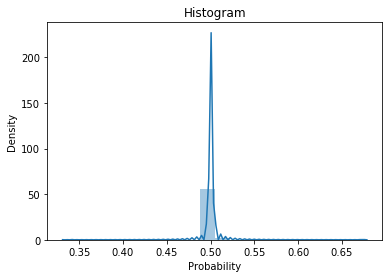

In [14]:
def create_hist(predict_prob, fname="histogram.png"):
    sns.distplot(prob[:,0], norm_hist=True, bins=20)
    plt.title("Histogram")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.savefig(fname)
    
create_hist(prob)

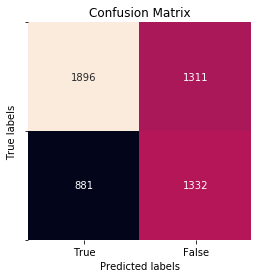

In [15]:
def create_cm(y_pred, y_real, fname="cm.png"):
    fig = plt.figure(figsize=(4,4))
    cm = confusion_matrix(y_pred, y_real)
    sns.heatmap(cm, annot=True, fmt='1d', cbar=False)
    plt.title("Confusion Matrix")
    plt.yticks(np.arange(0, 3, 1), [])
    plt.xticks(np.arange(0.5, 2, 1), ["True", "False"])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.savefig(fname)

create_cm(preds, Y)

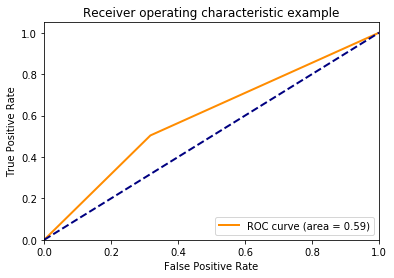

In [16]:
def create_roc(y_pred, y_real, fname="roc.png"):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(fname)
    plt.show()

create_roc(preds, Y)

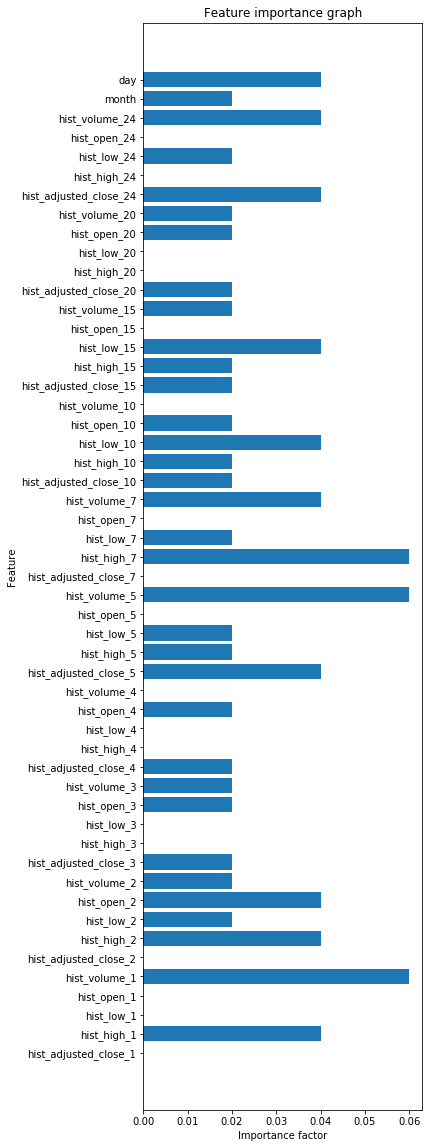

In [17]:
def create_fi(lr, fname="feature_importance.png"):
    tmp = lr.steps[1][1] #.feature_importance_
    feature_imp = tmp.feature_importances_
    features = stockTransformer(look_back).transform(df[:1]).columns
    plt.figure(figsize=(5,20))
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance factor')
    plt.ylabel('Feature')
    plt.barh(range(len(feature_imp)), feature_imp)
    plt.title('Feature importance graph')
    plt.savefig(fname)
    plt.show()

create_fi(lr)

# MLflow 

In [18]:
# Save model to MLFLOW
import mlflow
import mlflow.sklearn

mlflow.set_experiment(experiment_name)

mname = "ADABoost"

with mlflow.start_run():
    '''
        Log parameter, metrics, and model to MLflow
    '''    
    mlflow.log_param("Look-back-days", look_back)
    mlflow.log_param("X-train-shape", X.shape)
    mlflow.log_param("Days-into-future", days_into_future_target)
    
    mlflow.log_metric("ACC", acc)
    mlflow.log_metric("F1", f1)
    
    mlflow.set_tag("model", mname)
    mlflow.set_tag("model_type", model_type)
    
    mlflow.log_artifact("cm.png")
    mlflow.log_artifact("roc.png")
    mlflow.log_artifact("histogram.png")
    mlflow.log_artifact("feature_importance.png")

    lr.predict = lr.predict_proba
    mlflow.sklearn.log_model(lr, "model")
    print("Model saved to tracking- and artifact server")

Model saved to tracking- and artifact server


# MLflow - XGboost 

In [ ]:
# # Load training and test datasets
# import xgboost as xgb

# xgb_model = xgb.train(params={'max_depth': 10}, dtrain=dtrain, num_boost_round=10)
# xgb_model_path = "xgb_model.pth"
# xgb_model.save_model(xgb_model_path)

# artifacts = {
#     "xgb_model": xgb_model_path
# }

# # Define the model class
# import mlflow.pyfunc
# class XGBWrapper(mlflow.pyfunc.PythonModel):

#     def load_context(self, context):
#         import xgboost as xgb
#         self.xgb_model = xgb.Booster()
#         self.xgb_model.load_model(context.artifacts["xgb_model"])

#     def predict(self, context, model_input):
#         input_matrix = xgb.DMatrix(model_input.values)
#         return self.xgb_model.predict(input_matrix)

# # Create a Conda environment for the new MLflow Model that contains the XGBoost library
# # as a dependency, as well as the required CloudPickle library
# import cloudpickle
# conda_env = {
#     'channels': ['defaults'],
#     'dependencies': [
#       'xgboost={}'.format(xgb.__version__),
#       'cloudpickle={}'.format(cloudpickle.__version__),
#     ],
#     'name': 'xgb_env'
# }

# # Save the MLflow Model
# mlflow_pyfunc_model_path = "xgb_mlflow_pyfunc"
# mlflow.pyfunc.save_model(
#         path=mlflow_pyfunc_model_path, python_model=XGBWrapper(), artifacts=artifacts,
#         conda_env=conda_env)

# # Load the model in `python_function` format
# loaded_model = mlflow.pyfunc.load_model(mlflow_pyfunc_model_path)

# # Evaluate the model
# import pandas as pd
# test_predictions = loaded_model.predict(pd.DataFrame(x_test))
# print(test_predictions)
